In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from PIL import Image
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score,precision_recall_fscore_support

In [ ]:
# mount google drive to access files and folders
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# load train and test images for phase 2
train_df = pd.DataFrame(columns=['filepath','audio_class','img_arr'])
test_df = pd.DataFrame(columns=['filepath','audio_class','img_arr'])

cwd = os.getcwd()
print(cwd)

folder = ['image_train', 'image_test']
for t in folder:
  folder_path = cwd+'/gdrive/MyDrive/'+t
  audiofile_path = [folder_path+'/'+file for file in os.listdir(folder_path)]
  audio_class = [file.split(",")[-2] for file in os.listdir(folder_path)]
  file_df=pd.DataFrame({'filepath':audiofile_path,
                        'audio_class':audio_class})
  if t == 'image_train':
    train_df = pd.concat([train_df, file_df],ignore_index=True)
  else:
    test_df = pd.concat([test_df, file_df],ignore_index=True)

/content


In [ ]:
print(train_df.shape)
print(test_df.shape)

(383, 3)
(126, 3)


In [ ]:
# get image arr from imagepath and concat to dataframe
for idx, row in train_df.iterrows():
  #print(idx)
  path = row['filepath']
  image = Image.open(path).convert('RGB')
  image.thumbnail((224, 224))
  img_arr = np.array(image)
  normalized_img_arr = img_arr / 255.0
  train_df.at[idx,'img_arr'] = normalized_img_arr

print(train_df['img_arr'][20].shape)
print(train_df['img_arr'][5].shape)
print(train_df['img_arr'][115].shape)

(86, 224, 3)
(86, 224, 3)
(86, 224, 3)


In [ ]:
# get image arr from imagepath and concat to dataframe
for idx, row in test_df.iterrows():
  #print(idx)
  path = row['filepath']
  image = Image.open(path).convert('RGB')
  image.thumbnail((224, 224))
  img_arr = np.array(image)
  normalized_img_arr = img_arr / 255.0
  test_df.at[idx,'img_arr'] = normalized_img_arr

print(test_df['img_arr'][20].shape)
print(test_df['img_arr'][5].shape)
print(test_df['img_arr'][115].shape)

(86, 224, 3)
(86, 224, 3)
(86, 224, 3)


In [ ]:
# add a new column for binary class
train_df['binary_class'] = train_df['audio_class'].replace({'belly_pain': 'not_hungry', 'burping': 'not_hungry', 'discomfort': 'not_hungry', 'tired': 'not_hungry'})
test_df['binary_class'] = test_df['audio_class'].replace({'belly_pain': 'not_hungry', 'burping': 'not_hungry', 'discomfort': 'not_hungry', 'tired': 'not_hungry'})

print(train_df['audio_class'].value_counts())
print(train_df['binary_class'].value_counts())
print(test_df['audio_class'].value_counts())
print(test_df['binary_class'].value_counts())


hungry        283
tired          32
discomfort     30
belly_pain     22
burping        16
Name: audio_class, dtype: int64
hungry        283
not_hungry    100
Name: binary_class, dtype: int64
hungry        95
tired         11
discomfort     8
belly_pain     7
burping        5
Name: audio_class, dtype: int64
hungry        95
not_hungry    31
Name: binary_class, dtype: int64


In [ ]:
# train-val split for multi class classification
y_train = train_df['audio_class']
y_test = test_df['audio_class']

X_train, X_val, y_train, y_val = train_test_split(train_df, y_train, test_size=0.20, random_state=42, stratify=y_train)

In [ ]:
# train-val split for multi class classification
y_train_bin = train_df['binary_class']
y_test_bin = test_df['binary_class']

X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(train_df, y_train_bin, test_size=0.20, random_state=42, stratify=y_train_bin)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

print(X_train_bin.shape)
print(X_val_bin.shape)
print(y_train_bin.shape)
print(y_val_bin.shape)

print(y_test.shape)
print(y_test_bin.shape)

(306, 4)
(77, 4)
(306,)
(77,)
(306, 4)
(77, 4)
(306,)
(77,)
(126,)
(126,)


In [ ]:
print(y_train.value_counts())
print(y_train_bin.value_counts())

hungry        226
tired          25
discomfort     24
belly_pain     18
burping        13
Name: audio_class, dtype: int64
hungry        226
not_hungry     80
Name: binary_class, dtype: int64


In [ ]:
# label encoding
le = LabelEncoder()
le_bin = LabelEncoder()

y_train = to_categorical(le.fit_transform(y_train))
y_test = to_categorical(le.transform(y_test))
y_val = to_categorical(le.transform(y_val))

y_train_bin = to_categorical(le_bin.fit_transform(y_train_bin))
y_test_bin = to_categorical(le_bin.transform(y_test_bin))
y_val_bin= to_categorical(le_bin.transform(y_val_bin))

In [ ]:
# ResNet50 model
base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (86,224,3))
for layer in base_model.layers:
  layer.trainable = False

234698864/234698864 [==============================] - 12s 0us/step


In [ ]:
# build the entire model1
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation = 'softmax')(x)

In [ ]:
#model 2
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(5, activation = 'softmax')(x)

In [ ]:
#model 2
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(2, activation = 'softmax')(x)

In [ ]:
# Convert numpy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train['img_arr'].values.tolist())
X_val_tensor = tf.convert_to_tensor(X_val['img_arr'].values.tolist())
X_test_tensor = tf.convert_to_tensor(test_df['img_arr'].values.tolist())
y_train_tensor = tf.convert_to_tensor(y_train)
y_val_tensor = tf.convert_to_tensor(y_val)
y_test_tensor = tf.convert_to_tensor(y_test)

X_train_bin_tensor = tf.convert_to_tensor(X_train_bin['img_arr'].values.tolist())
X_val_bin_tensor = tf.convert_to_tensor(X_val_bin['img_arr'].values.tolist())
X_test_tensor = tf.convert_to_tensor(test_df['img_arr'].values.tolist())
y_train_bin_tensor = tf.convert_to_tensor(y_train_bin)
y_val_bin_tensor = tf.convert_to_tensor(y_val_bin)
y_test_bin_tensor = tf.convert_to_tensor(y_test_bin)

In [ ]:
def report_performance(y_test,y_pred):
    # calculate precision, recall, and f1 based on the cry reason of orginal audio and predictions
    precision_1, recall_1,f1_1, null_value_1 = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)

    precision_2, recall_2,f1_2, null_value_2 = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    # calucate accuracy rate
    accuracy = accuracy_score(y_test,y_pred)
    return {
        'precision_macro': precision_1,
        'recall_macro': recall_1,
        'f1_macro': f1_1,
        'precision_weighted': precision_2,
        'recall_weighted': recall_2,
        'f1_weighted': f1_2,
        'accuracy': accuracy
    }

In [ ]:
#multiclass
final_model = Model(inputs = base_model.input, outputs = predictions)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# save the best training weights
model_callback_checkpoint = ModelCheckpoint(filepath='cnn_model/bestmodel.h5',save_best_only=True, monitor='val_loss')
history = final_model.fit(X_train_tensor, y_train_tensor, batch_size=64, epochs=100, validation_data=(X_val_tensor, y_val_tensor), callbacks=[model_callback_checkpoint])
# load the saved model
new_model = load_model('cnn_model/bestmodel.h5')

Epoch 1/100
5/5 [==============================] - 22s 2s/step - loss: 1.0437 - categorical_accuracy: 0.7026 - val_loss: 1.0623 - val_categorical_accuracy: 0.7403
Epoch 2/100
5/5 [==============================] - 3s 627ms/step - loss: 1.0799 - categorical_accuracy: 0.7386 - val_loss: 0.9216 - val_categorical_accuracy: 0.7403
Epoch 3/100
5/5 [==============================] - 1s 273ms/step - loss: 0.9614 - categorical_accuracy: 0.7386 - val_loss: 0.9810 - val_categorical_accuracy: 0.7403
Epoch 4/100
5/5 [==============================] - 3s 728ms/step - loss: 0.9395 - categorical_accuracy: 0.7386 - val_loss: 0.9207 - val_categorical_accuracy: 0.7403
Epoch 5/100
5/5 [==============================] - 4s 966ms/step - loss: 0.9331 - categorical_accuracy: 0.7386 - val_loss: 0.9183 - val_categorical_accuracy: 0.7403
Epoch 6/100
5/5 [==============================] - 1s 282ms/step - loss: 0.9464 - categorical_accuracy: 0.7386 - val_loss: 0.9208 - val_categorical_accuracy: 0.7403
Epoch 7/100


4/4 [==============================] - 6s 318ms/step


,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy
0,0.39435,0.301299,0.316966,0.692987,0.793651,0.725983,0.793651


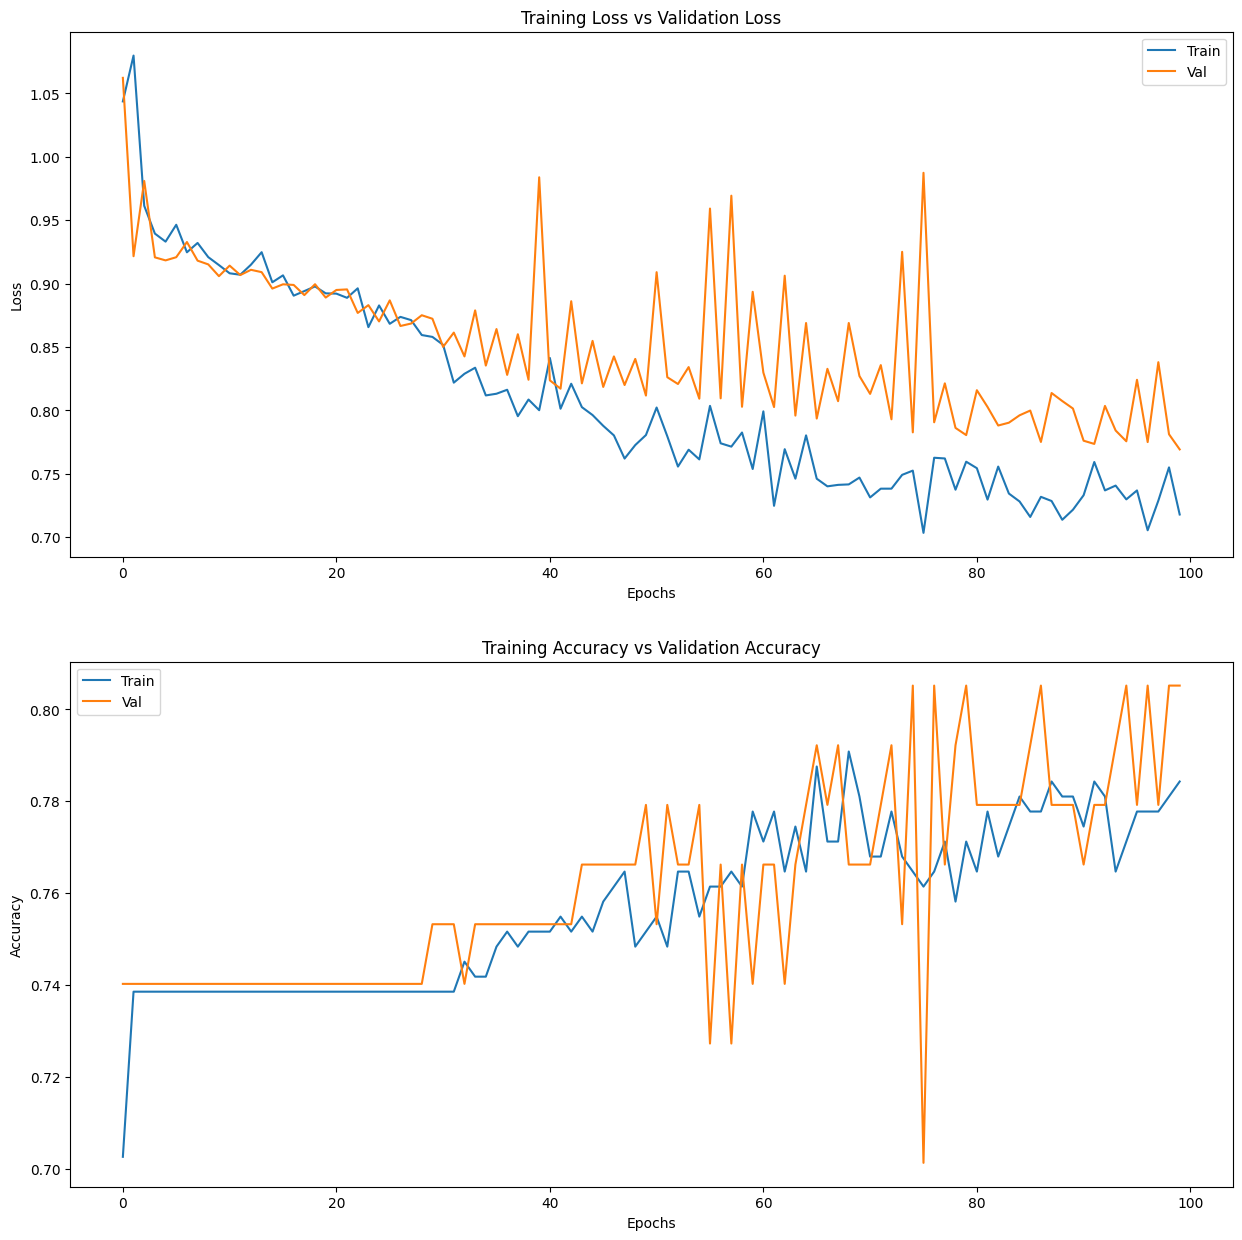

In [ ]:
# get model predictions on test data
predictions = new_model.predict(X_test_tensor)
# since the have our predictions in binary matrix we get the index of the highest prob value
y_pred = np.argmax(predictions, axis = 1)
# we apply inverse of label encoder to get the corresponding lables of the numeric values
y_pred_labels = le.inverse_transform(y_pred)

fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['categorical_accuracy'])
axs[1].plot(history.history['val_categorical_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

# calculate performance metrics
# since the have our predictions in binary matrix we get the index of the highest prob value
y_test = np.argmax(y_test, axis = 1)
y_test_labels = le.inverse_transform(y_test)

metrics_dict = report_performance(y_test_labels,y_pred_labels)
metrics_df = pd.Series(metrics_dict).to_frame().T

metrics_df

In [ ]:
# ResNet50 model
base_model_bin = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (86,224,3))
for layer in base_model_bin.layers:
  layer.trainable = False

In [ ]:
# build the entire model1
x = base_model_bin.output
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
predictions_bin = layers.Dense(2, activation = 'softmax')(x)

In [ ]:
#Binary
final_model_bin = Model(inputs = base_model_bin.input, outputs = predictions_bin)
final_model_bin.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# save the best training weights
model_callback_checkpoint = ModelCheckpoint(filepath='cnn_model/bestmodel.h5',save_best_only=True, monitor='val_loss')
history_bin = final_model_bin.fit(X_train_bin_tensor, y_train_bin_tensor, batch_size=64, epochs=100, validation_data=(X_val_bin_tensor, y_val_bin_tensor), callbacks=[model_callback_checkpoint])
# load the saved model
new_model_bin = load_model('cnn_model/bestmodel.h5')

Epoch 1/100
5/5 [==============================] - 25s 4s/step - loss: 0.6370 - accuracy: 0.6765 - val_loss: 0.5765 - val_accuracy: 0.7403
Epoch 2/100
5/5 [==============================] - 10s 2s/step - loss: 0.5756 - accuracy: 0.7386 - val_loss: 0.5706 - val_accuracy: 0.7403
Epoch 3/100
5/5 [==============================] - 1s 281ms/step - loss: 0.5745 - accuracy: 0.7386 - val_loss: 0.5719 - val_accuracy: 0.7403
Epoch 4/100
5/5 [==============================] - 5s 1s/step - loss: 0.5804 - accuracy: 0.7386 - val_loss: 0.5702 - val_accuracy: 0.7403
Epoch 5/100
5/5 [==============================] - 1s 292ms/step - loss: 0.5707 - accuracy: 0.7386 - val_loss: 0.5716 - val_accuracy: 0.7403
Epoch 6/100
5/5 [==============================] - 7s 2s/step - loss: 0.5665 - accuracy: 0.7386 - val_loss: 0.5639 - val_accuracy: 0.7403
Epoch 7/100
5/5 [==============================] - 8s 2s/step - loss: 0.5642 - accuracy: 0.7386 - val_loss: 0.5628 - val_accuracy: 0.7403
Epoch 8/100
5/5 [=========

4/4 [==============================] - 10s 149ms/step


,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy
0,0.88,0.516129,0.463068,0.819048,0.761905,0.666531,0.761905


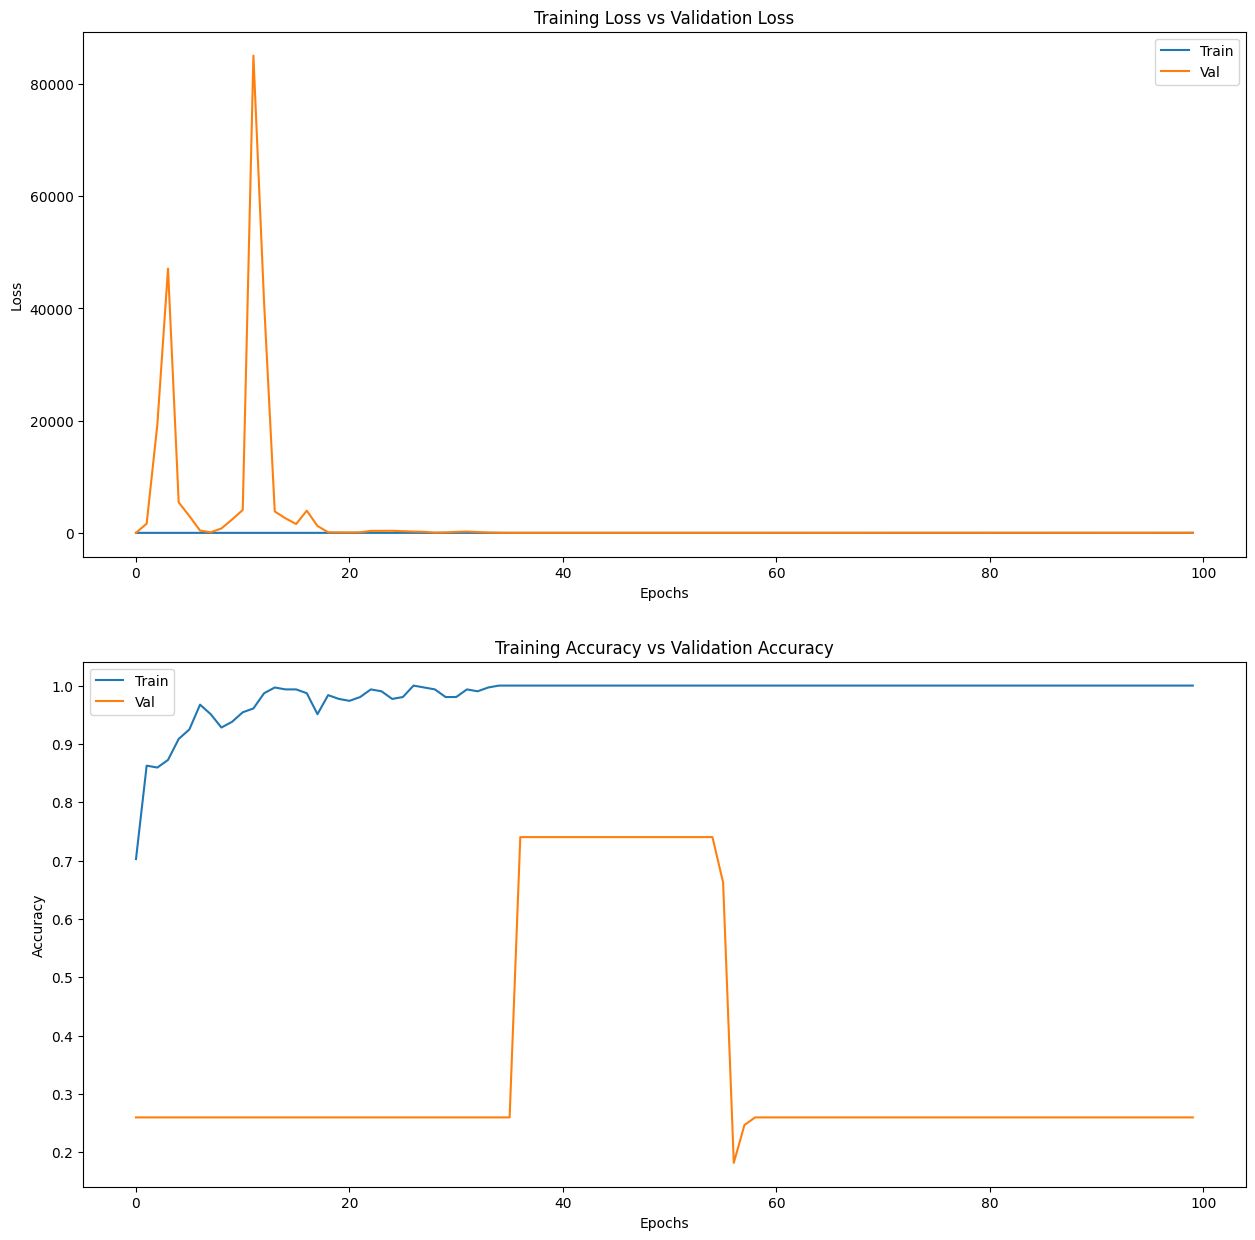

In [ ]:
# get model predictions on test data
predictions_bin = new_model_bin.predict(X_test_tensor)
# since the have our predictions in binary matrix we get the index of the highest prob value
y_pred_bin = np.argmax(predictions_bin, axis = 1)
# we apply inverse of label encoder to get the corresponding lables of the numeric values
y_pred_bin_labels = le_bin.inverse_transform(y_pred_bin)

fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history_bin.history['loss'])
axs[0].plot(history_bin.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history_bin.history['accuracy'])
axs[1].plot(history_bin.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

# calculate performance metrics
# since the have our predictions in binary matrix we get the index of the highest prob value
y_test_bin = np.argmax(y_test_bin, axis = 1)
y_test_bin_labels = le_bin.inverse_transform(y_test_bin)

metrics_dict = report_performance(y_test_bin_labels,y_pred_bin_labels)
metrics_df = pd.Series(metrics_dict).to_frame().T

metrics_df



## **2nd model**

In [ ]:
# ResNet50 model
base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (86,224,3))
for layer in base_model.layers:
  layer.trainable = False

 #model 2
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(5, activation = 'softmax')(x)

Epoch 1/100
5/5 [==============================] - 24s 3s/step - loss: 5.4831 - categorical_accuracy: 0.5850 - val_loss: 7.1402 - val_categorical_accuracy: 0.0779
Epoch 2/100
5/5 [==============================] - 17s 4s/step - loss: 5.2968 - categorical_accuracy: 0.3301 - val_loss: 5.0263 - val_categorical_accuracy: 0.7403
Epoch 3/100
5/5 [==============================] - 14s 3s/step - loss: 4.8436 - categorical_accuracy: 0.7386 - val_loss: 2.7138 - val_categorical_accuracy: 0.7403
Epoch 4/100
5/5 [==============================] - 15s 4s/step - loss: 2.3443 - categorical_accuracy: 0.3725 - val_loss: 1.0261 - val_categorical_accuracy: 0.7532
Epoch 5/100
5/5 [==============================] - 1s 296ms/step - loss: 1.2258 - categorical_accuracy: 0.7484 - val_loss: 1.3815 - val_categorical_accuracy: 0.7662
Epoch 6/100
5/5 [==============================] - 1s 285ms/step - loss: 1.2020 - categorical_accuracy: 0.7516 - val_loss: 1.1430 - val_categorical_accuracy: 0.7532
Epoch 7/100
5/5 [=

ValueError: ignored

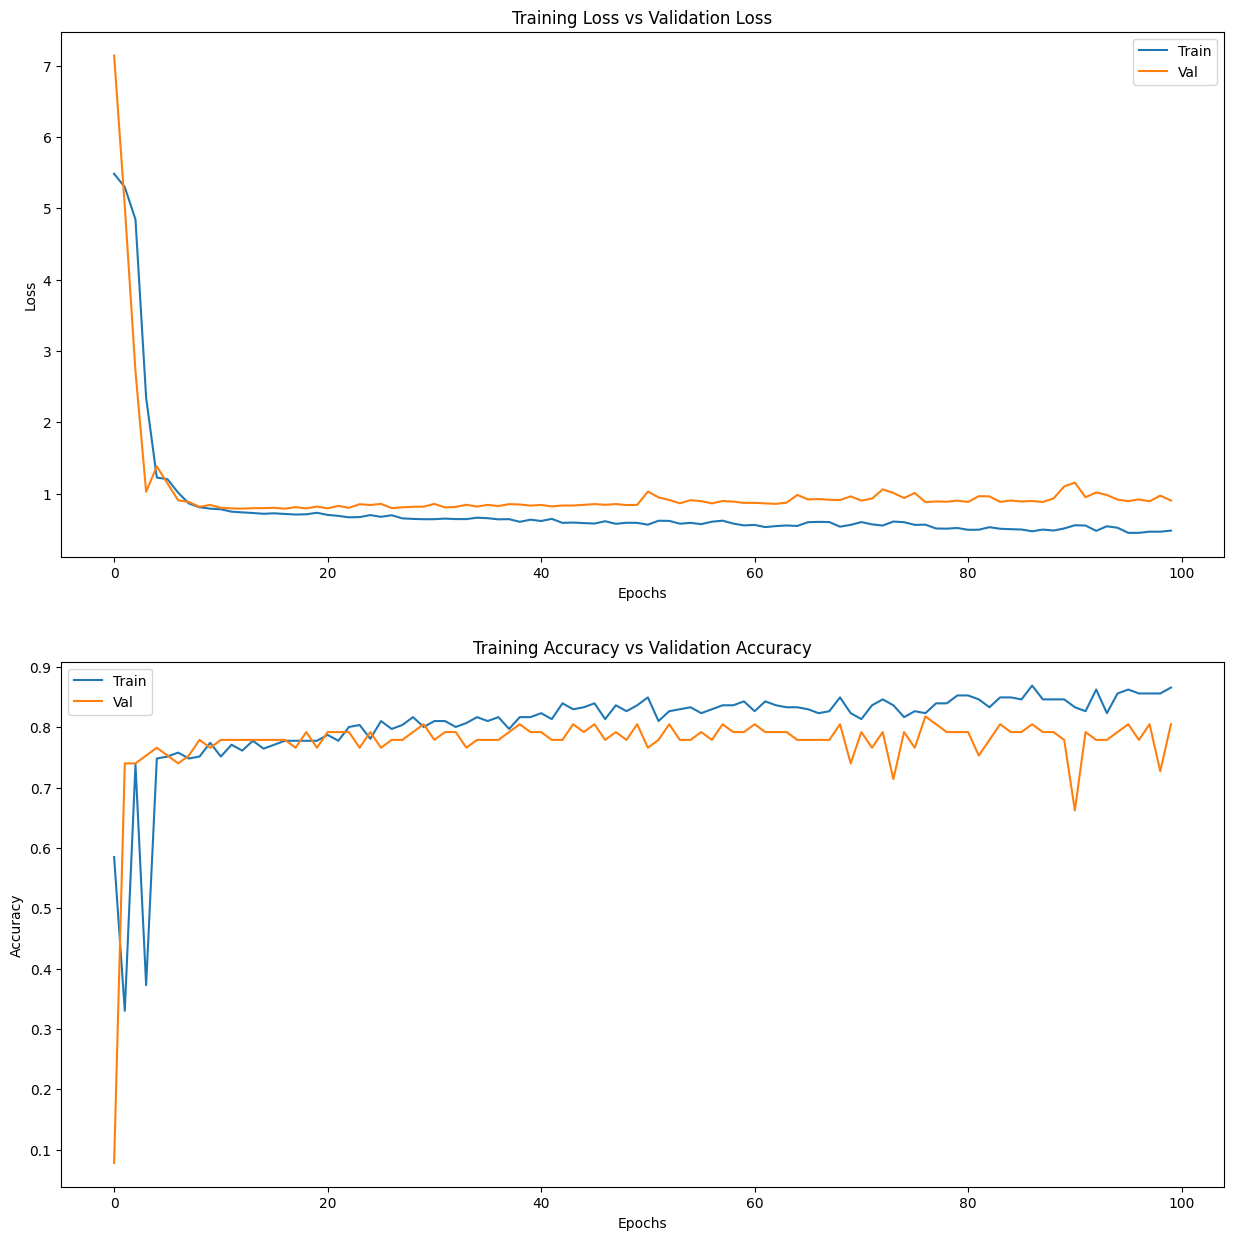

In [ ]:
#multiclass
final_model = Model(inputs = base_model.input, outputs = predictions)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# save the best training weights
model_callback_checkpoint = ModelCheckpoint(filepath='cnn_model/bestmodel.h5',save_best_only=True, monitor='val_loss')
history = final_model.fit(X_train_tensor, y_train_tensor, batch_size=64, epochs=100, validation_data=(X_val_tensor, y_val_tensor), callbacks=[model_callback_checkpoint])
# load the saved model
new_model = load_model('cnn_model/bestmodel.h5')

# get model predictions on test data
predictions = new_model.predict(X_test_tensor)
# since the have our predictions in binary matrix we get the index of the highest prob value
y_pred = np.argmax(predictions, axis = 1)
# we apply inverse of label encoder to get the corresponding lables of the numeric values
y_pred_labels = le.inverse_transform(y_pred)

fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['categorical_accuracy'])
axs[1].plot(history.history['val_categorical_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

# calculate performance metrics
# since the have our predictions in binary matrix we get the index of the highest prob value
#y_test = np.argmax(y_test, axis = 1)
#y_test_labels = le.inverse_transform(y_test)

#metrics_dict = report_performance(y_test_labels,y_pred_labels)
metrics_dict = report_performance(y_test,y_pred_labels)
metrics_df = pd.Series(metrics_dict).to_frame().T

metrics_df


In [ ]:
metrics_dict = report_performance(y_test_labels,y_pred_labels)
#metrics_dict = report_performance(y_test,y_pred_labels)
metrics_df = pd.Series(metrics_dict).to_frame().T

metrics_df

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy
0,0.457025,0.276364,0.294607,0.699101,0.777778,0.701413,0.777778


In [ ]:
#model 2
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(2, activation = 'softmax')(x)

Epoch 1/100
5/5 [==============================] - 27s 4s/step - loss: 3.9536 - accuracy: 0.7386 - val_loss: 2.3289 - val_accuracy: 0.7403
Epoch 2/100
5/5 [==============================] - 10s 2s/step - loss: 1.1744 - accuracy: 0.5621 - val_loss: 0.8490 - val_accuracy: 0.2597
Epoch 3/100
5/5 [==============================] - 10s 2s/step - loss: 0.7199 - accuracy: 0.6144 - val_loss: 0.6069 - val_accuracy: 0.7403
Epoch 4/100
5/5 [==============================] - 1s 263ms/step - loss: 0.6266 - accuracy: 0.7451 - val_loss: 0.6370 - val_accuracy: 0.7403
Epoch 5/100
5/5 [==============================] - 10s 2s/step - loss: 0.5875 - accuracy: 0.7484 - val_loss: 0.5281 - val_accuracy: 0.7662
Epoch 6/100
5/5 [==============================] - 1s 264ms/step - loss: 0.5314 - accuracy: 0.7778 - val_loss: 0.5514 - val_accuracy: 0.8571
Epoch 7/100
5/5 [==============================] - 9s 2s/step - loss: 0.5247 - accuracy: 0.8007 - val_loss: 0.5134 - val_accuracy: 0.7792
Epoch 8/100
5/5 [=======

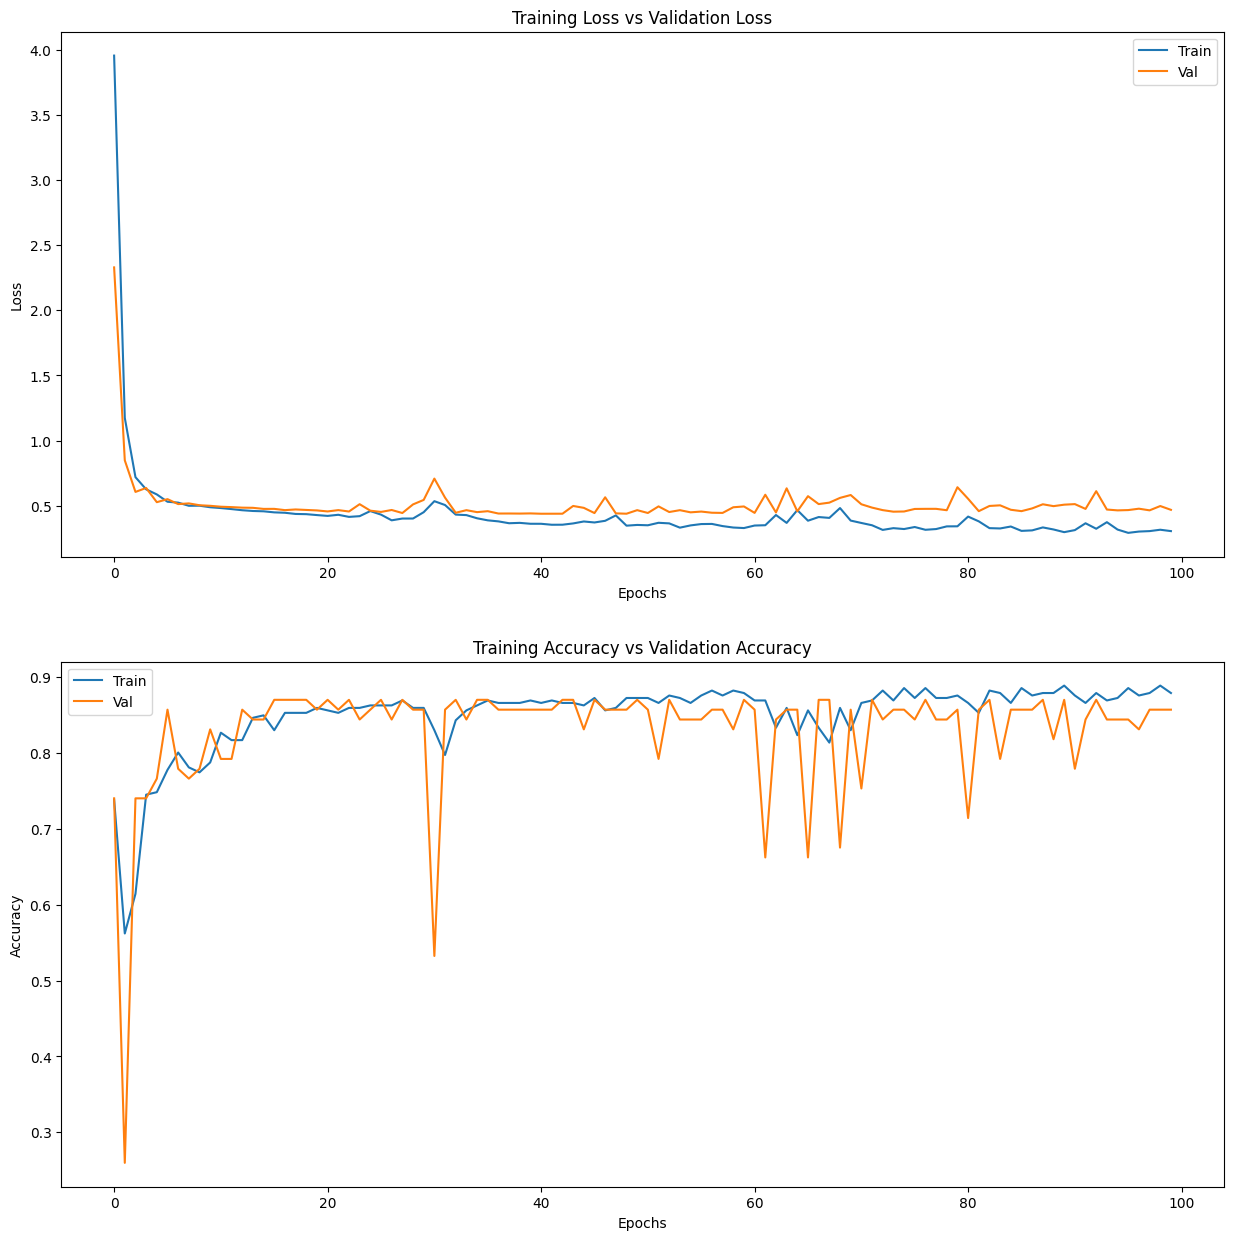

In [ ]:

#Binary
final_model = Model(inputs = base_model.input, outputs = predictions)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# save the best training weights
model_callback_checkpoint = ModelCheckpoint(filepath='cnn_model/bestmodel.h5',save_best_only=True, monitor='val_loss')
history = final_model.fit(X_train_bin_tensor, y_train_bin_tensor, batch_size=64, epochs=100, validation_data=(X_val_bin_tensor, y_val_bin_tensor), callbacks=[model_callback_checkpoint])
# load the saved model
new_model = load_model('cnn_model/bestmodel.h5')

# get model predictions on test data
predictions = new_model.predict(X_test_tensor)
# since the have our predictions in binary matrix we get the index of the highest prob value
y_pred = np.argmax(predictions, axis = 1)
# we apply inverse of label encoder to get the corresponding lables of the numeric values
y_pred_labels = le_bin.inverse_transform(y_pred)

fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])





In [ ]:
y_test_bin[0]

array([0., 1.], dtype=float32)

In [ ]:
# calculate performance metrics
# since the have our predictions in binary matrix we get the index of the highest prob value
y_test_bin = np.argmax(y_test_bin, axis = 1)
y_test_bin_labels = le_bin.inverse_transform(y_test_bin)

metrics_dict = report_performance(y_test_bin_labels,y_pred_labels)
metrics_df = pd.Series(metrics_dict).to_frame().T

metrics_df

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy
0,0.902542,0.629032,0.651138,0.85304,0.81746,0.77349,0.81746


## **VGGNET**

In [ ]:
# train-val split for multi class classification
y_train = train_df['audio_class']
y_test = test_df['audio_class']

X_train, X_val, y_train, y_val = train_test_split(train_df, y_train, test_size=0.20, random_state=42, stratify=y_train)

In [ ]:
# train-val split for multi class classification
y_train_bin = train_df['binary_class']
y_test_bin = test_df['binary_class']

X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(train_df, y_train_bin, test_size=0.20, random_state=42, stratify=y_train_bin)

In [ ]:
# label encoding
le = LabelEncoder()
le_bin = LabelEncoder()

y_train = to_categorical(le.fit_transform(y_train))
y_test = to_categorical(le.transform(y_test))
y_val = to_categorical(le.transform(y_val))

y_train_bin = to_categorical(le_bin.fit_transform(y_train_bin))
y_test_bin = to_categorical(le_bin.transform(y_test_bin))
y_val_bin= to_categorical(le_bin.transform(y_val_bin))

In [ ]:
# Convert numpy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train['img_arr'].values.tolist())
X_val_tensor = tf.convert_to_tensor(X_val['img_arr'].values.tolist())
X_test_tensor = tf.convert_to_tensor(test_df['img_arr'].values.tolist())
y_train_tensor = tf.convert_to_tensor(y_train)
y_val_tensor = tf.convert_to_tensor(y_val)
y_test_tensor = tf.convert_to_tensor(y_test)

X_train_bin_tensor = tf.convert_to_tensor(X_train_bin['img_arr'].values.tolist())
X_val_bin_tensor = tf.convert_to_tensor(X_val_bin['img_arr'].values.tolist())
#X_test_tensor = tf.convert_to_tensor(test_df['img_arr'].values.tolist())
y_train_bin_tensor = tf.convert_to_tensor(y_train_bin)
y_val_bin_tensor = tf.convert_to_tensor(y_val_bin)
y_test_bin_tensor = tf.convert_to_tensor(y_test_bin)

In [ ]:
vgg_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (86,224,3))
for layer in vgg_model.layers:
  layer.trainable = False
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 86, 224, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 86, 224, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 86, 224, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 43, 112, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 43, 112, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 43, 112, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 21, 56, 128)       0     

In [ ]:
x = layers.Flatten()(vgg_model.output)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation = 'softmax')(x)


In [ ]:
#Binary

x = layers.Flatten()(vgg_model.output)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(2, activation = 'softmax')(x)


In [ ]:
#multiclass
vggfinal_model = Model(inputs = vgg_model.input, outputs = predictions)
vggfinal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# save the best training weights
model_callback_checkpoint = ModelCheckpoint(filepath='cnn_model/bestmodel.h5',save_best_only=True, monitor='val_loss')
history_vgg = vggfinal_model.fit(X_train_tensor, y_train_tensor, batch_size=64, epochs=100, validation_data=(X_val_tensor, y_val_tensor), callbacks=[model_callback_checkpoint])
# load the saved model
new_model = load_model('cnn_model/bestmodel.h5')

Epoch 1/100
5/5 [==============================] - 18s 3s/step - loss: 5.5938 - categorical_accuracy: 0.4902 - val_loss: 1.5964 - val_categorical_accuracy: 0.6883
Epoch 2/100
5/5 [==============================] - 7s 2s/step - loss: 1.1848 - categorical_accuracy: 0.7386 - val_loss: 0.9984 - val_categorical_accuracy: 0.7662
Epoch 3/100
5/5 [==============================] - 7s 2s/step - loss: 0.8316 - categorical_accuracy: 0.7647 - val_loss: 0.8295 - val_categorical_accuracy: 0.7792
Epoch 4/100
5/5 [==============================] - 7s 2s/step - loss: 0.7429 - categorical_accuracy: 0.7843 - val_loss: 0.8080 - val_categorical_accuracy: 0.7662
Epoch 5/100
5/5 [==============================] - 1s 205ms/step - loss: 0.7727 - categorical_accuracy: 0.7876 - val_loss: 0.8270 - val_categorical_accuracy: 0.7922
Epoch 6/100
5/5 [==============================] - 3s 744ms/step - loss: 0.7044 - categorical_accuracy: 0.7941 - val_loss: 0.7951 - val_categorical_accuracy: 0.7792
Epoch 7/100
5/5 [====

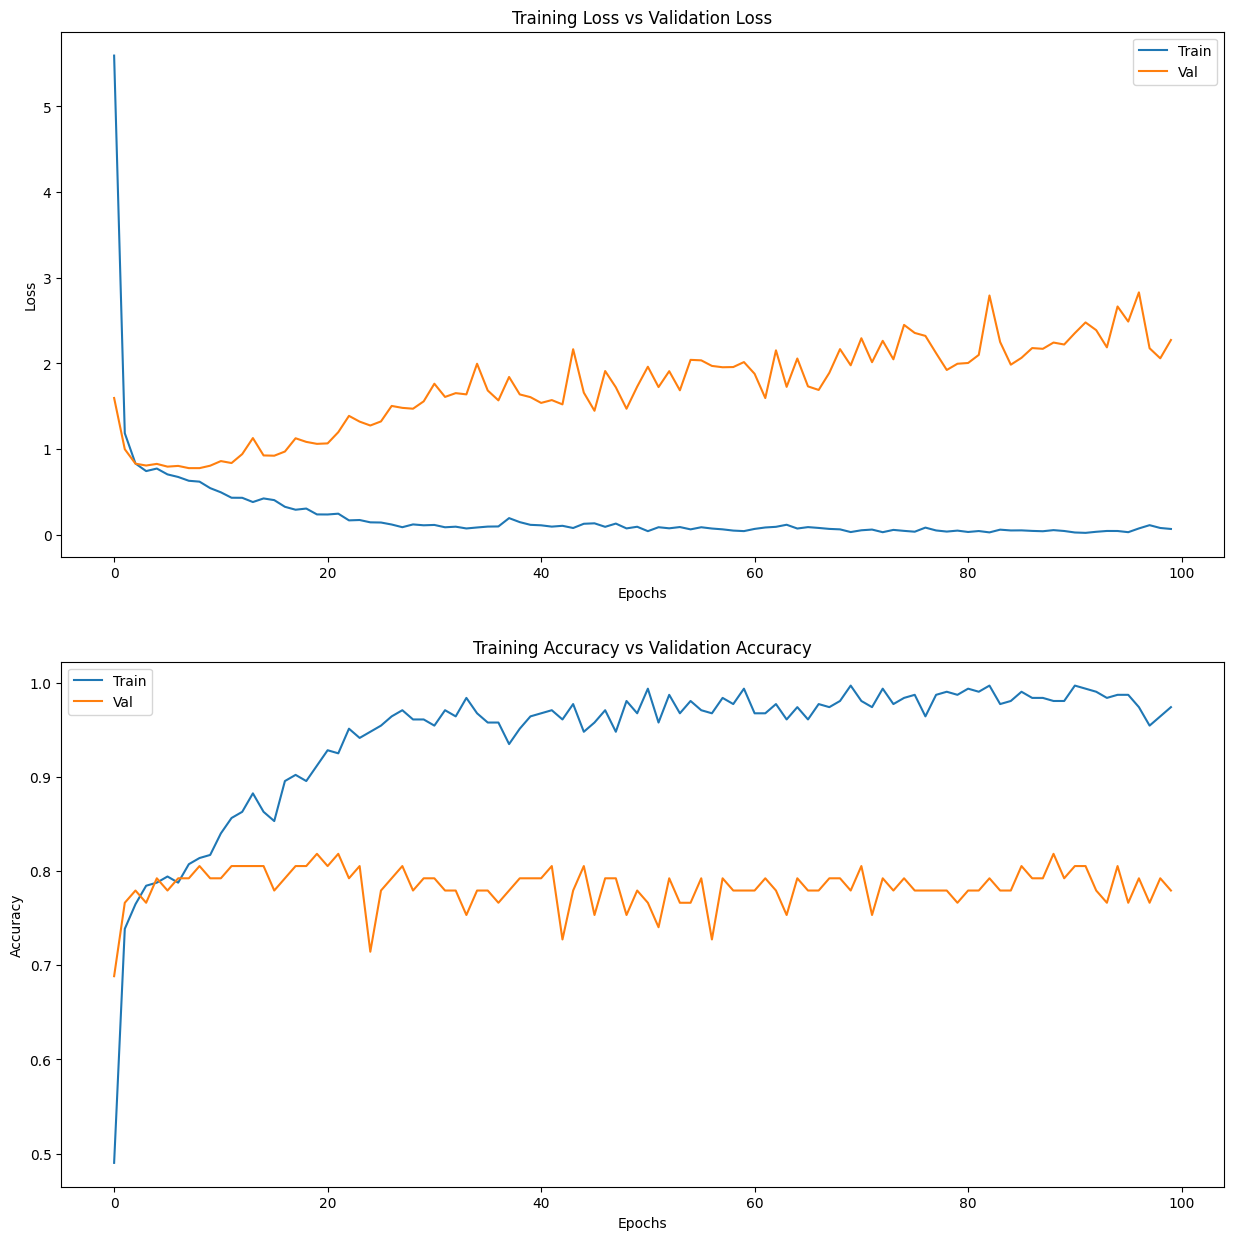

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history_vgg.history['loss'])
axs[0].plot(history_vgg.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history_vgg.history['categorical_accuracy'])
axs[1].plot(history_vgg.history['val_categorical_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
# get model predictions on test data
#predictions = new_model.predict(X_test_tensor)
# since the have our predictions in binary matrix we get the index of the highest prob value
#y_pred = np.argmax(predictions, axis = 1)
# we apply inverse of label encoder to get the corresponding lables of the numeric values
#y_pred_labels = le.inverse_transform(y_pred)


# calculate performance metrics
# since the have our predictions in binary matrix we get the index of the highest prob value
#y_test = np.argmax(y_test, axis = 1)
#y_test_labels = le.inverse_transform(y_test)

metrics_dict = report_performance(y_test_labels,y_pred_labels)
metrics_df = pd.Series(metrics_dict).to_frame().T

metrics_df

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy
0,0.627684,0.333506,0.378831,0.763093,0.793651,0.734028,0.793651


In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(306, 5)
(77, 5)
(126,)


In [ ]:
vggfinal_bin_model = Model(inputs = vgg_model.input, outputs = predictions)
vggfinal_bin_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# save the best training weights
model_callback_checkpoint = ModelCheckpoint(filepath='cnn_model/bestmodel.h5',save_best_only=True, monitor='val_loss')
history_vgg_bin = vggfinal_bin_model.fit(X_train_bin_tensor, y_train_bin_tensor, batch_size=64, epochs=100, validation_data=(X_val_bin_tensor, y_val_bin_tensor), callbacks=[model_callback_checkpoint])
# load the saved model
new_model_bin = load_model('cnn_model/bestmodel.h5')

Epoch 1/100
5/5 [==============================] - 7s 1s/step - loss: 2.9973 - accuracy: 0.6340 - val_loss: 2.0566 - val_accuracy: 0.7403
Epoch 2/100
5/5 [==============================] - 6s 2s/step - loss: 1.2706 - accuracy: 0.7451 - val_loss: 0.6374 - val_accuracy: 0.8701
Epoch 3/100
5/5 [==============================] - 5s 1s/step - loss: 0.4941 - accuracy: 0.8431 - val_loss: 0.4694 - val_accuracy: 0.8701
Epoch 4/100
5/5 [==============================] - 8s 2s/step - loss: 0.4230 - accuracy: 0.8464 - val_loss: 0.4450 - val_accuracy: 0.8701
Epoch 5/100
5/5 [==============================] - 6s 2s/step - loss: 0.4016 - accuracy: 0.8660 - val_loss: 0.4342 - val_accuracy: 0.8701
Epoch 6/100
5/5 [==============================] - 5s 1s/step - loss: 0.3318 - accuracy: 0.8725 - val_loss: 0.4280 - val_accuracy: 0.8701
Epoch 7/100
5/5 [==============================] - 1s 163ms/step - loss: 0.3211 - accuracy: 0.8627 - val_loss: 0.4375 - val_accuracy: 0.8701
Epoch 8/100
5/5 [==============

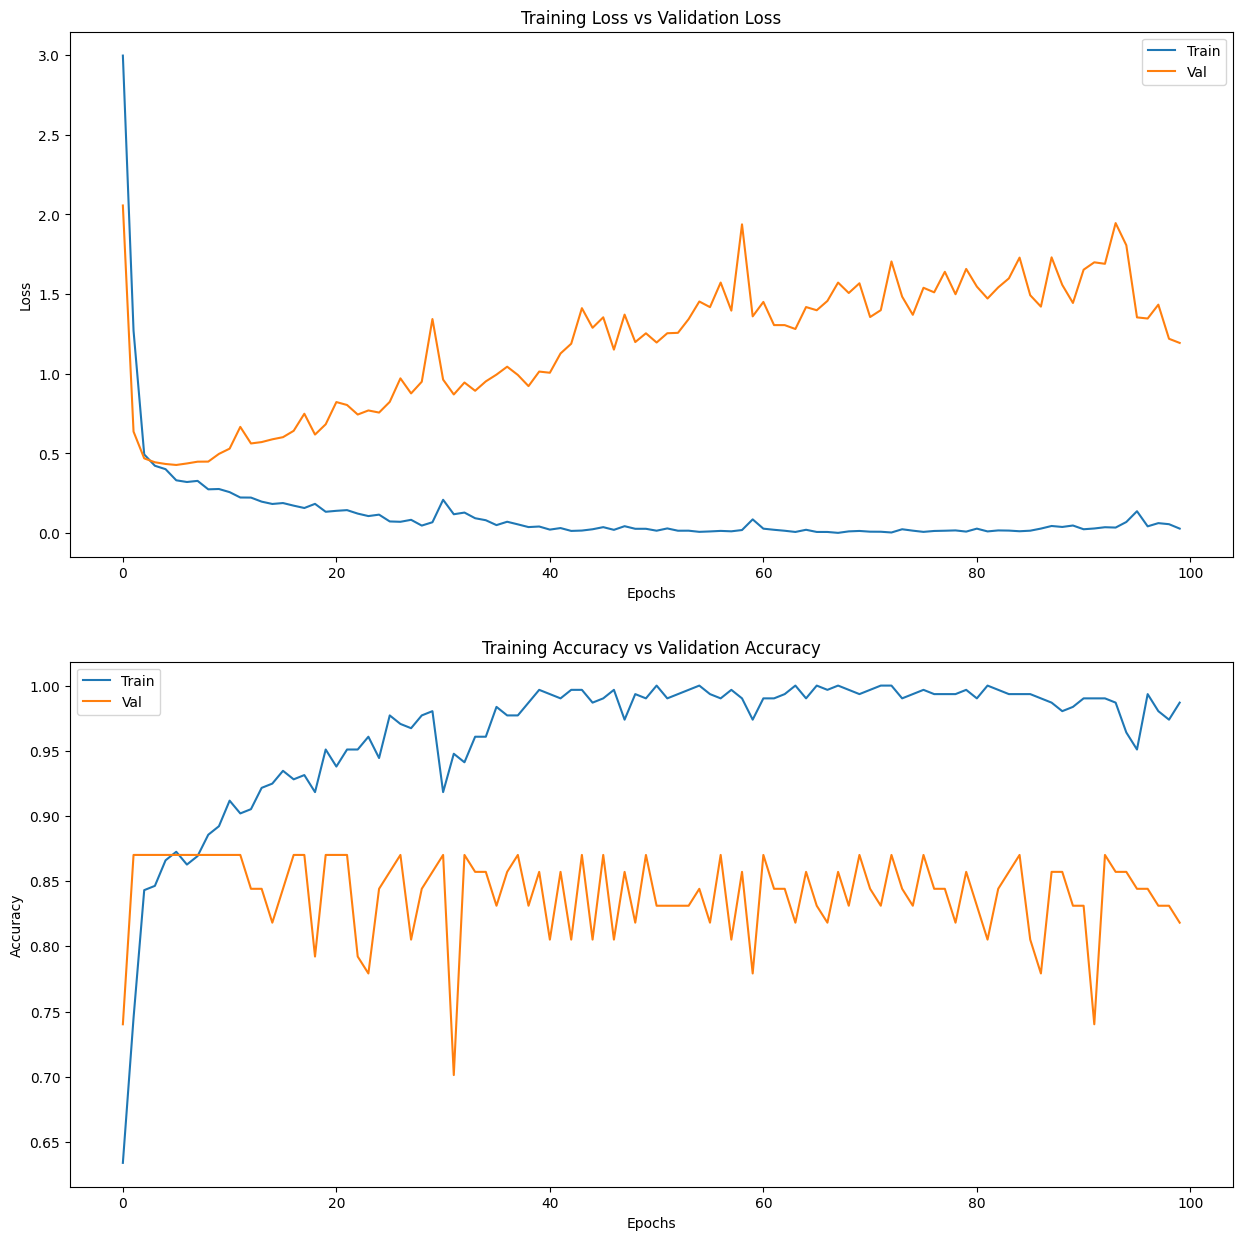

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history_vgg_bin.history['loss'])
axs[0].plot(history_vgg_bin.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history_vgg_bin.history['accuracy'])
axs[1].plot(history_vgg_bin.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
# get model predictions on test data
predictions_bin = new_model_bin.predict(X_test_tensor)
# since the have our predictions in binary matrix we get the index of the highest prob value
y_pred_bin = np.argmax(predictions_bin, axis = 1)
# we apply inverse of label encoder to get the corresponding lables of the numeric values
y_pred_bin_labels = le_bin.inverse_transform(y_pred_bin)


# calculate performance metrics
# since the have our predictions in binary matrix we get the index of the highest prob value
y_test_bin = np.argmax(y_test_bin, axis = 1)
y_test_bin_labels = le_bin.inverse_transform(y_test_bin)

metrics_dict = report_performance(y_test_bin_labels,y_pred_bin_labels)
metrics_df = pd.Series(metrics_dict).to_frame().T

metrics_df

4/4 [==============================] - 0s 78ms/step


,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy
0,0.902542,0.629032,0.651138,0.85304,0.81746,0.77349,0.81746
